# DenseNet

**DenseNet** es una red neuronal convolucional ligera diseñada para aplicaciones de visión por computadora en dispositivos móviles. Tiene una arquitectura eficiente y un tamaño relativamente pequeño, lo que la hace adecuada para comparaciones rápidas.

## Configuración

In [1]:
path = "../../"

### Bibliotecas

In [2]:
# Importar las bibliotecas necesarias

# Arrays y vectores
import pandas as pd
import numpy as np

import datetime
import os
import random

# Mostrar imágenes
import matplotlib.pyplot as plt
import cv2

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Matriz de Confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Constantes

In [3]:
TARGET_IMG_WIDTH = 224
TARGET_IMG_HEIGHT = 224
TARGET_IMG_CHANNELS = 3
TARGET_SIZE = (TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT)
TARGET_SHAPE = (TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT, TARGET_IMG_CHANNELS)

BATCH_SIZE = 32

NUMBER_EPOCHS = 60

INITIAL_WEIGHTS = 'imagenet'

OPTIMIZER = Adam()
LOSS = tf.keras.losses.SparseCategoricalCrossentropy()

EARLYSTOP_MONITOR = 'val_loss'
EARLYSTOP_PATIENCE = 10

LR_MONITOR = 'val_loss'
LR_FACTOR = 0.5
LR_PATIENCE = 5
LR_MINLR = 0.0001

CHECKPOINT_MONITOR = 'val_accuracy'
CHECKPOINT_MODE = 'max'

# METRICS = [tf.keras.metrics.Accuracy, tf.keras.metrics.Precision, tf.keras.metrics.Recall]
METRICS = ['accuracy']
# METRICS = ['accuracy', 'loss', 'precision', 'recall', 'f1_score', 'auc_roc', 'sensitivity', 'specificity', 'top_k_accuracy']

In [4]:
# Obtener la fecha y hora actual
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M")

### Verificar GPU

In [5]:
tf.config.set_visible_devices([], 'GPU')

# if tf.test.gpu_device_name(): # this lies and tells you about all devices
if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [6]:
'''# Verificar si hay una GPU disponible
if tf.config.list_physical_devices('GPU'):
    print('TensorFlow está utilizando la GPU')

    # Crear un tensor en la GPU
    with tf.device('/GPU:0'):
        tensor = tf.constant([1, 2, 3])

    # Realizar alguna operación en la GPU
    result = tensor * 2

    # Imprimir el resultado
    print(result)
else:
    print('TensorFlow está utilizando la CPU')'''

"# Verificar si hay una GPU disponible\nif tf.config.list_physical_devices('GPU'):\n    print('TensorFlow está utilizando la GPU')\n\n    # Crear un tensor en la GPU\n    with tf.device('/GPU:0'):\n        tensor = tf.constant([1, 2, 3])\n\n    # Realizar alguna operación en la GPU\n    result = tensor * 2\n\n    # Imprimir el resultado\n    print(result)\nelse:\n    print('TensorFlow está utilizando la CPU')"

### Paths del Dataset

In [7]:
# Ruta del archivo CSV de entrada
csv_path = path + "CSVs/dataset.csv"
csv_train = path + "CSVs/dataset/train.csv"
csv_test = path + "CSVs/dataset/test.csv"
csv_val = path + "CSVs/dataset/val.csv"

# Ruta del directorio donde se encuentran las imágenes
DATASET_PATH = path + "Dataset/"

### Lectura de los archivos CSVs

In [8]:
# Lectura de los archivos CSV
df_train = pd.read_csv(csv_train)
df_test = pd.read_csv(csv_test)
df_val = pd.read_csv(csv_val)

In [9]:
# Número de clases
NUM_CLASSES = df_train['class'].nunique()

In [10]:
CLASSES = df_train['class'].unique()
#CLASSES = set(CLASSES)
# CLASSES

## Creación del modelo

#### Base

MobileNetV2 es una red neuronal convolucional ligera diseñada para aplicaciones de visión por computadora en dispositivos móviles. Tiene una arquitectura eficiente y un tamaño relativamente pequeño, lo que la hace adecuada para comparaciones rápidas. Puedes utilizar el módulo tensorflow.keras.applications.mobilenet_v2 para cargar el modelo pre-entrenado y ajustarlo a tus necesidades.

In [11]:
# Configuración de la red DenseNet
MODEL_NAME = "DenseNet"
# Configuración de la red DenseNet121
from tensorflow.keras.applications.densenet import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

29084464/29084464 [==============================] - 200s 7us/step


#### Últimas capas

In [12]:
# Últimas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x) # varias capas en prof no en anchura 512 - 128 - 64 ...
x = Dense(64, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

#### Modelo Final

In [13]:
# Modelo Final
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
# Congelar los pesos de las capas base (excepto las últimas capas añadidas)
for layer in base_model.layers:
    layer.trainable = False

In [15]:
# Compilar el modelo
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

## Data Augmentation

### Aumento de datos

In [17]:
# Aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # vertical_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

### Generador de conjuntos

In [18]:
# Crear generador de datos para el conjunto de entrenamiento
train_datagen = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=DATASET_PATH,
    x_col='path',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    suffle = True,
    # color_mode='rgb',
    class_mode='sparse'
)

# Crear generador de datos para el conjunto de validación
valid_datagen = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=DATASET_PATH,
    x_col='path',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    suffle = True,
    class_mode='sparse'
)

# Crear generador de datos para el conjunto de prueba
test_datagen = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=DATASET_PATH,
    x_col='path',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    suffle = True,
    class_mode='sparse'
)

Found 6391 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 799 validated image filenames belonging to 8 classes.


## Control de entrenamiento (Callbacks)

In [19]:
# Estimación del error en el conjunto de validación
# validation_steps = len(df_val) // BATCH_SIZE

#### Early Stopping

**EarlyStopping**: Detiene el entrenamiento si no se observa una mejora en la métrica especificada (por ejemplo, la pérdida o la precisión en el conjunto de validación) durante un número determinado de épocas consecutivas. Ayuda a evitar el sobreajuste y a ahorrar tiempo de entrenamiento. Puedes configurar parámetros como monitor (la métrica a monitorear), patience (el número de épocas sin mejora antes de detener el entrenamiento) y mode (si se debe maximizar o minimizar la métrica).

In [20]:
# Definir Early Stopping
early_stopping = EarlyStopping(monitor=EARLYSTOP_MONITOR, patience=EARLYSTOP_PATIENCE)

#### Model CheckPoint

**ModelCheckpoint** guardará los modelos en cada época donde se cumpla la condición especificada.

In [21]:
# Definir el patrón de nombres para los archivos de modelos guardados
checkpoint_filename = f"best_model_{current_datetime}_{{val_accuracy:.4f}}.h5"

# Combinar el directorio y el patrón de nombres
checkpoint_path = path + "Models/" + MODEL_NAME + "/" + checkpoint_filename

# Definir el callback ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor=CHECKPOINT_MONITOR,
    mode=CHECKPOINT_MODE,
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#### ReduceLROnPlateau

**ReduceLROnPlateau**: Reduce la tasa de aprendizaje (learning rate) cuando una métrica monitoreada deja de mejorar. Esto puede ayudar a ajustar mejor el modelo durante el entrenamiento y mejorar su convergencia.

A configurar:
- monitor: la métrica a monitorear
- factor: el factor de reducción del learning rate
- patience: el número de épocas sin mejora antes de reducir el learning rate
- mode: si se debe maximizar o minimizar la métrica

In [22]:
# Definir ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor=LR_MONITOR, factor=LR_FACTOR, patience=LR_PATIENCE, min_lr=LR_MINLR, verbose = 1)
# monitor = mean_absolute_error

#### TensorBoard

**TensorBoard**: Permite visualizar métricas, gráficas y otros detalles del entrenamiento en TensorBoard, una herramienta de visualización de TensorFlow. Esto te proporciona una interfaz gráfica para analizar y comparar los resultados del entrenamiento a lo largo del tiempo. Puedes especificar la carpeta de registro (log_dir) para guardar los datos de entrenamiento y luego ejecutar TensorBoard para ver los resultados.

In [23]:
# Definir TensorBoard
log_dir = path + "Logs/" + MODEL_NAME + "/"
# tensorboard = TensorBoard(log_dir=log_dir)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    embeddings_freq=1,
    )

# Una vez iniciado el entrenamiento, en la terminal ejecutar:
# tensorboard --logdir=/content/drive/MyDrive/NeuralNetwork/logs/
# tensorboard --logdir=Logs/DenseNet/

#### CSVLogger

**CSVLogger**: Registra las métricas de entrenamiento y validación en un archivo CSV. Esto te permite realizar un seguimiento de las métricas a lo largo del tiempo y analizarlas posteriormente. Puedes especificar el nombre del archivo CSV (filename) donde se guardarán las métricas.

In [24]:
# Definir CSVLogger

# Definir el nombre del archivo con la fecha incluida
csvlogger_filename = path + "CSVLogs/" + MODEL_NAME + "/" + current_datetime + "_training.log"

csv_logger = CSVLogger(filename=csvlogger_filename)

In [25]:
model_callbacks = [early_stopping, checkpoint, reduce_lr, tensorboard, csv_logger]
# csv_logger

In [26]:
step_size_train = train_datagen.n // train_datagen.batch_size

In [28]:
# Entrenar el modelo
history = model.fit(
    train_datagen,
    #steps_per_epoch=step_size_train,  # len(df_train), # // train_datagen.batch_size,
    validation_data=valid_datagen,
    # validation_steps=validation_steps, # todo mirar
    epochs=NUMBER_EPOCHS,
    callbacks=model_callbacks
)

# todo por qué hace el mismo numero de pasos para train y valid, si son dos conjuntos difefentes, con diferente numero de imgs (7500/16 (batch) = 469 aprox, y luego 1000/16 = 59, pero con train y val hace 469 paso en cada
# Current batch being processed over total batches. Depends on the batch size and your total training instances.
# steps_per_epoch the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter. -> steps_per_epoch is used to generate the entire dataset once by calling the generator steps_per_epoch times
# validation_steps similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.

Epoch 1/60
200/200 [==============================] - ETA: 0s - loss: 1.1117 - accuracy: 0.5966
Epoch 1: val_accuracy did not improve from 0.52250
200/200 [==============================] - 473s 2s/step - loss: 1.1117 - accuracy: 0.5966 - val_loss: 1.4460 - val_accuracy: 0.4988 - lr: 0.0010
Epoch 2/60
200/200 [==============================] - ETA: 0s - loss: 1.0324 - accuracy: 0.6325
Epoch 2: val_accuracy improved from 0.52250 to 0.54750, saving model to ../../Models/DenseNet\best_model_20230621_1729_0.5475.h5
200/200 [==============================] - 474s 2s/step - loss: 1.0324 - accuracy: 0.6325 - val_loss: 1.2786 - val_accuracy: 0.5475 - lr: 0.0010
Epoch 3/60
200/200 [==============================] - ETA: 0s - loss: 0.9769 - accuracy: 0.6636
Epoch 3: val_accuracy improved from 0.54750 to 0.60250, saving model to ../../Models/DenseNet\best_model_20230621_1729_0.6025.h5
200/200 [==============================] - 497s 2s/step - loss: 0.9769 - accuracy: 0.6636 - val_loss: 1.1667 - va

### Visualizar como ha ido el entrenamiento

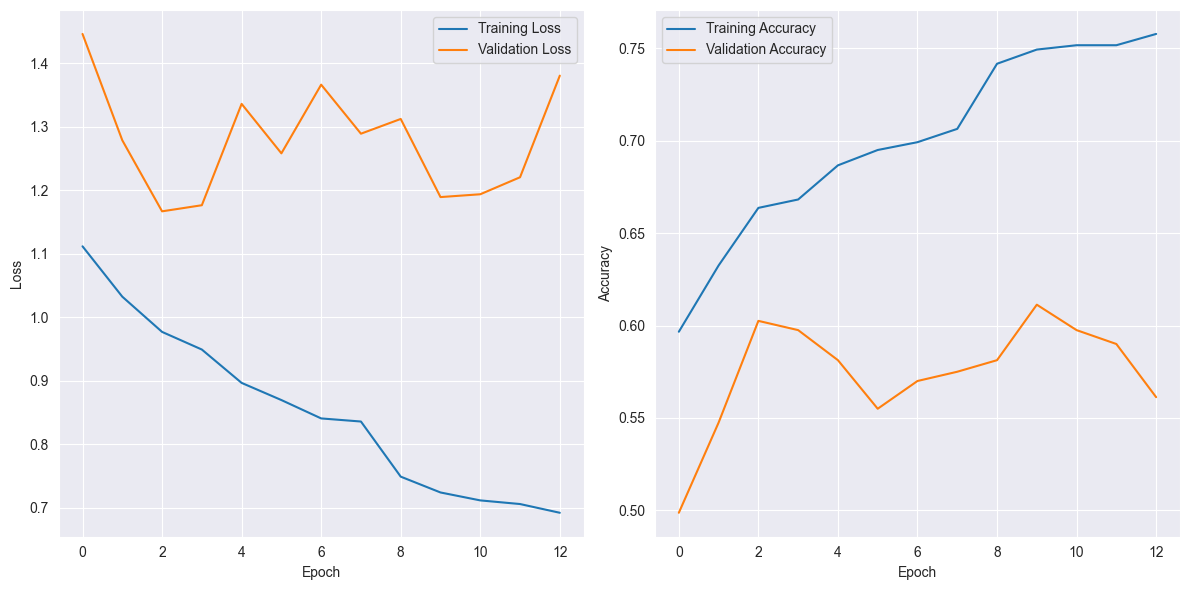

In [30]:
# Cargar los datos del archivo CSV
log_data = pd.read_csv(csvlogger_filename)

# Graficar la pérdida y la precisión
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(log_data['epoch'], log_data['loss'], label='Training Loss')
plt.plot(log_data['epoch'], log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log_data['epoch'], log_data['accuracy'], label='Training Accuracy')
plt.plot(log_data['epoch'], log_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluación del modelo

In [31]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_datagen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

25/25 [==============================] - 37s 1s/step - loss: 0.9702 - accuracy: 0.6871
Test Loss: 0.9702
Test Accuracy: 0.6871


In [32]:
predictions = model.predict(test_datagen)

25/25 [==============================] - 39s 1s/step


In [33]:
predicted_classes = np.argmax(predictions, axis=1)
df_predictions = pd.DataFrame(data = predictions)

In [34]:
# Obtener las etiquetas únicas en el DataFrame df_test
# unique_labels = df_test['class'].unique()

class_indices = test_datagen.class_indices
unique_labels = list(class_indices.keys())

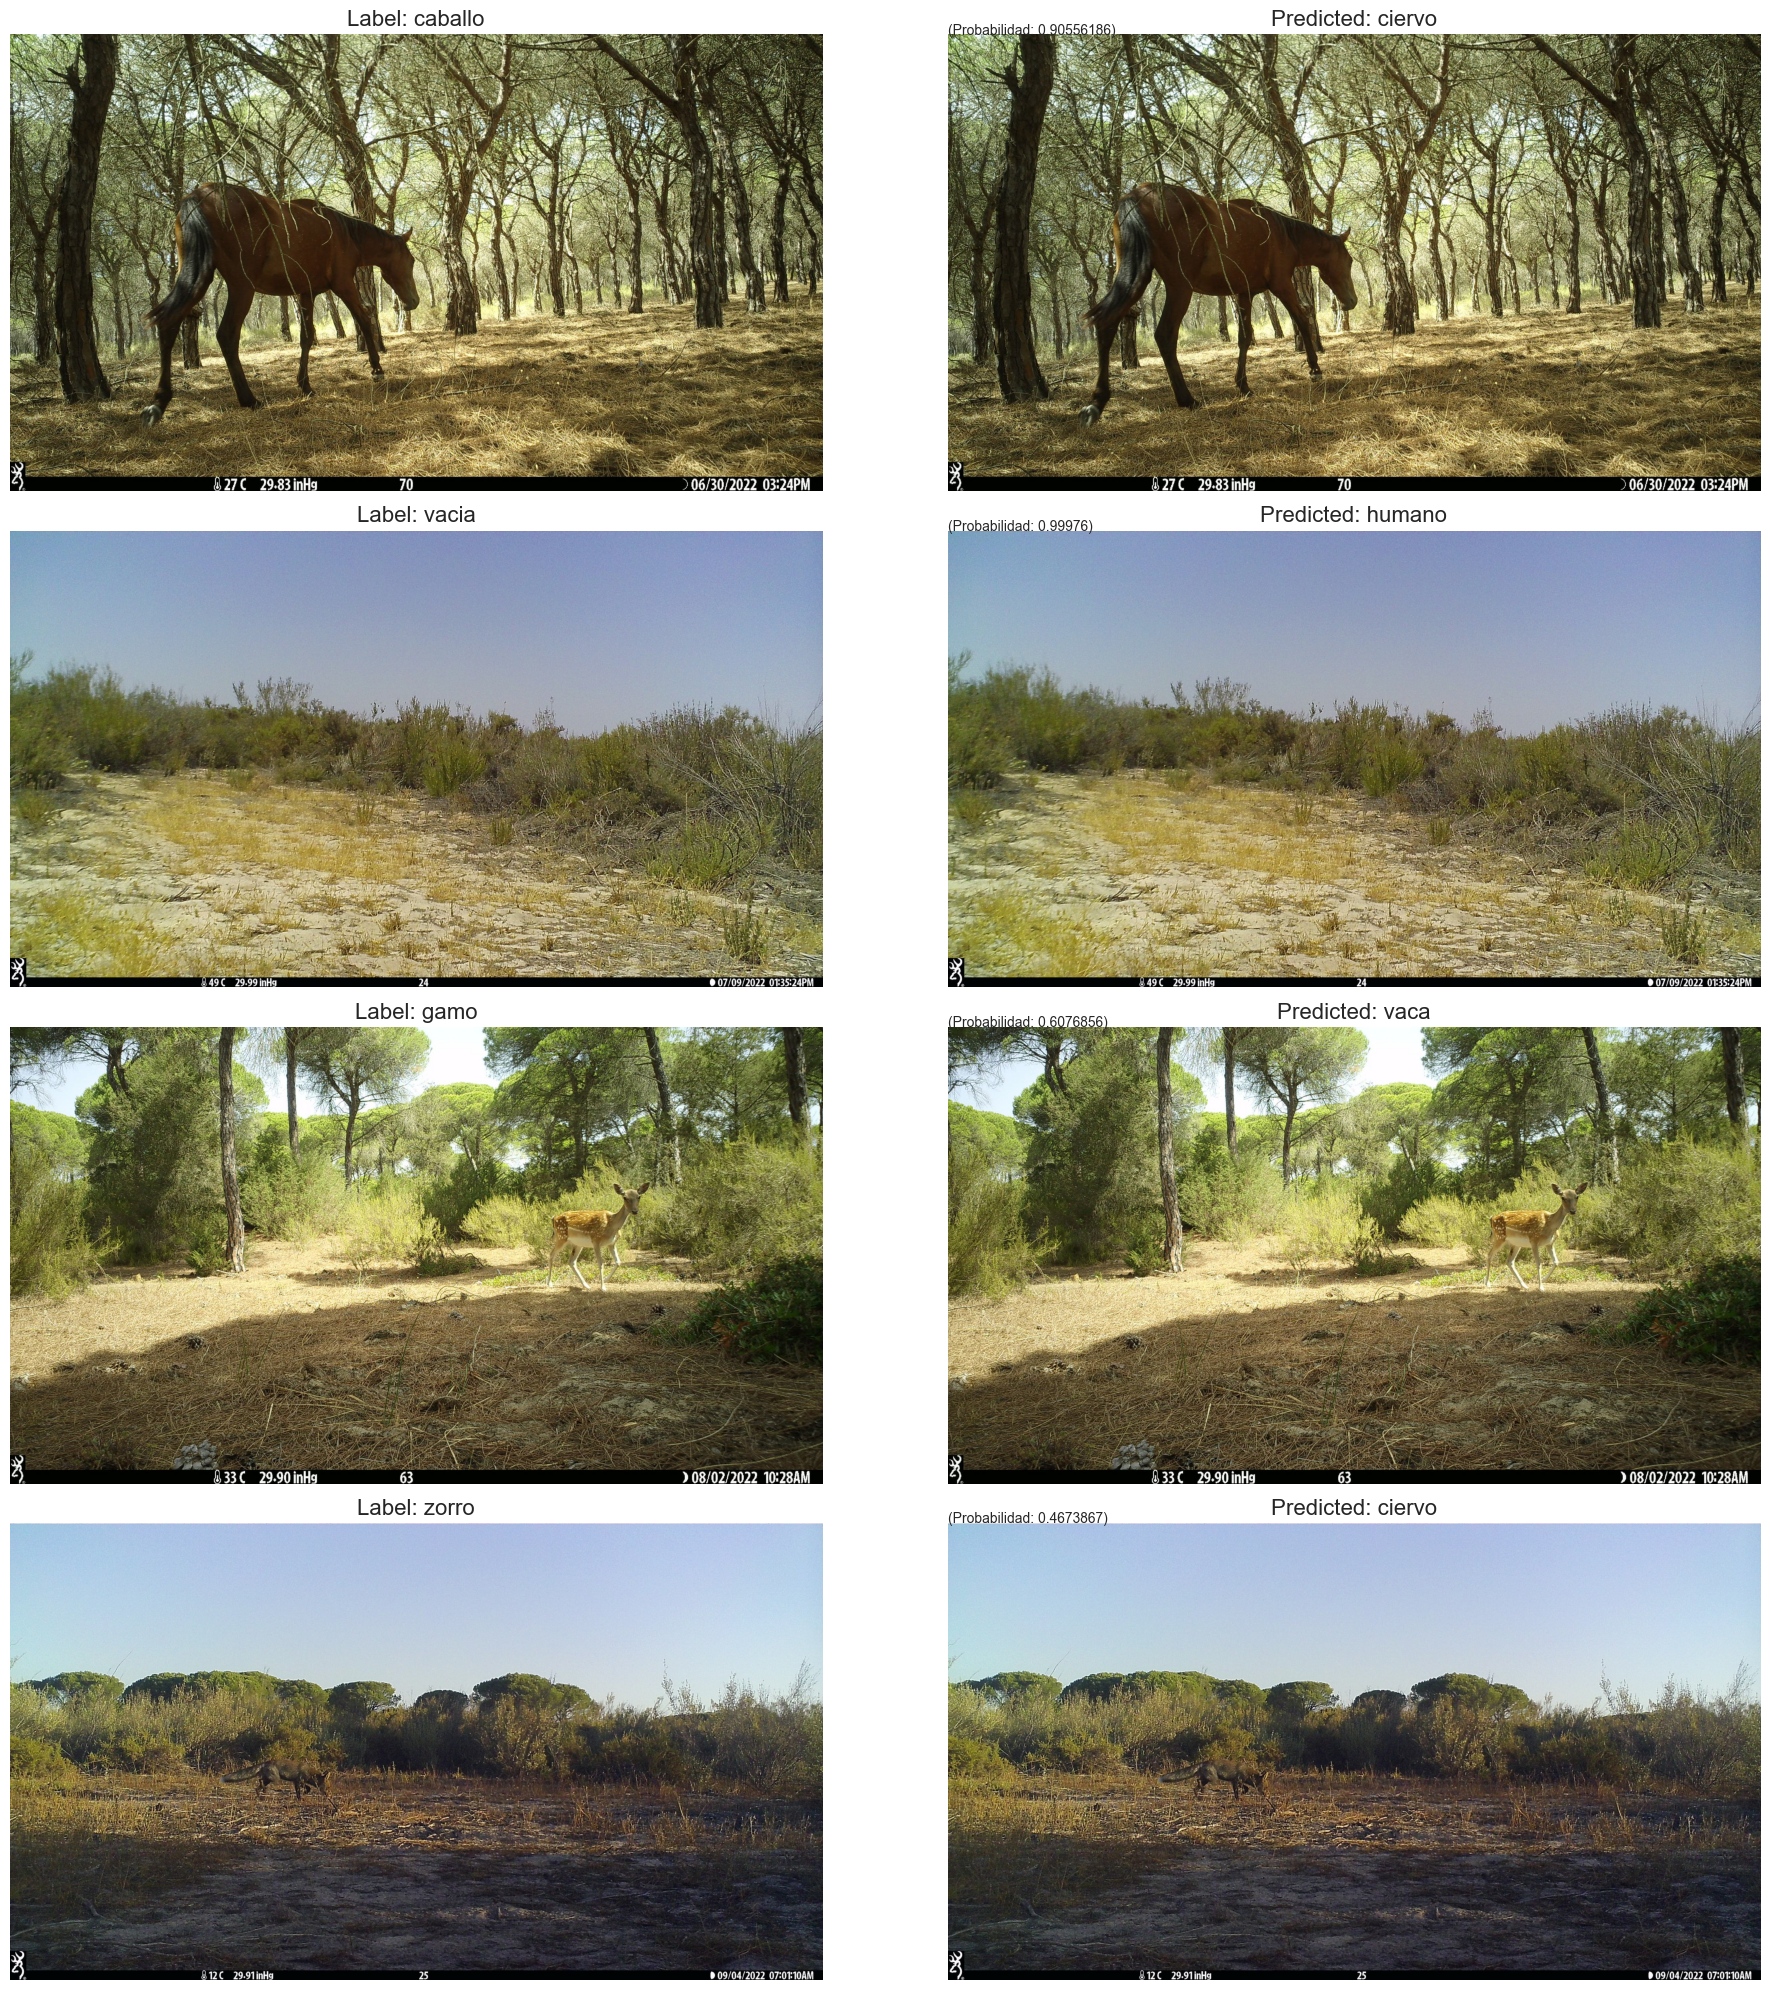

In [36]:
num_images = 4

fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(20, 20))

for i, ax_row in enumerate(axs):

    # Elegimos una imagen aleatoria
    sample = random.choice(range(len(df_test)))

    # Predicciones actuales
    current_predictions = df_predictions.loc[[sample], :]
    current_prediction = np.argmax(current_predictions)

    # Graficamos la imagen elegida
    image = cv2.imread(path + "Dataset/" + df_test['path'][sample])
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Mostrar la imagen en ambos subplots
    ax_row[0].imshow(image_rgb)
    ax_row[0].axis('off')
    ax_row[1].imshow(image_rgb)
    ax_row[1].axis('off')

    # Añadir cualquier información adicional en el título o en el espacio debajo de los subplots
    ax_row[0].set_title('Label: {}'.format(df_test['class'][sample]), fontsize=16)
    ax_row[1].set_title('Predicted: {}'.format(unique_labels[predicted_classes[sample]]), fontsize=16)
    ax_row[1].text(0.5, 0.5, '(Probabilidad: ' + str(current_predictions[current_prediction].iloc[0]) + ')')

plt.tight_layout()
plt.show()


### Matriz de Confusión

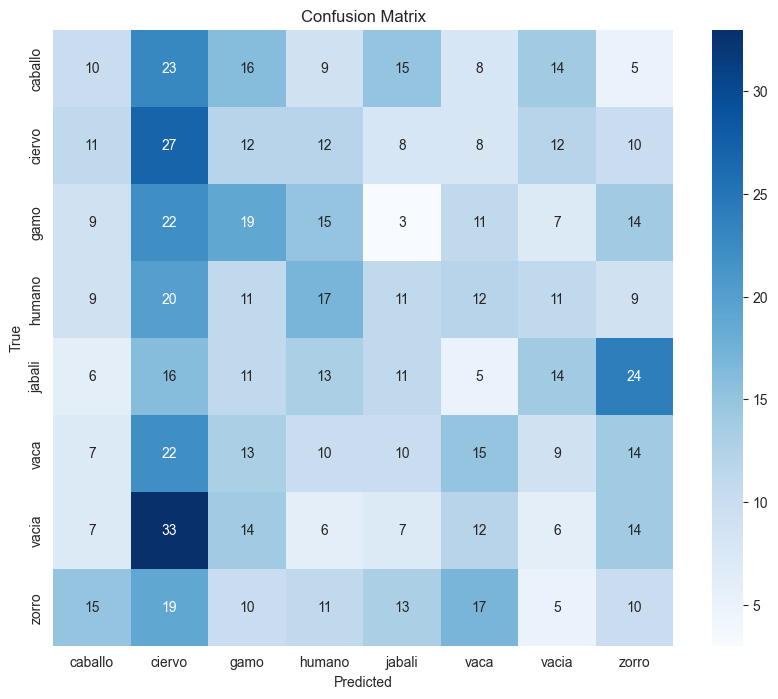

In [37]:
# Obtener las etiquetas verdaderas
y_true = test_datagen.labels
# y_true = np.argmax(test_datagen.labels, axis=1)

# Calcular la matriz de confusión
confusion_matrix = confusion_matrix(y_true, predicted_classes)

# Crear el mapa de calor de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# Generar las etiquetas verdaderas
y_true = []
for batch in test_datagen:
    labels = batch[1]
    y_true.extend(np.argmax(labels, axis=1))
    if len(y_true) >= len(df_test):
        break

# Calcular y mostrar la matriz de confusión
cm = confusion_matrix(y_true, predicted_classes)
print(cm)